<a href="https://colab.research.google.com/github/jeffdi/tt_ml_test/blob/main/Pytorch_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An example implementation of a simple neural network using PyTorch and Tiny Tapeout

In this notebook, we are going to train a simple neural network using PyTorch and implement it in silicon using Tiny Tapeout.

This example reimplements the Hello World example presented in Chapter 4 of the TinyML book by Pat Warden.

https://www.oreilly.com/library/view/tinyml/9781492052036/ch04.html

---

**Author:** TBD

## Importing dependencies

In addition to PyTorch, we are going to use a Github project for converting a neural network model to Verilog.  

https://github.com/rohittp0/chipon/tree/master



In [2]:
!git clone https://github.com/rohittp0/chipon
%cd chipon/

Cloning into 'chipon'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 40 (delta 1), reused 4 (delta 1), pack-reused 31
Receiving objects: 100% (40/40), 45.40 MiB | 24.90 MiB/s, done.
Resolving deltas: 100% (8/8), done.
/content/chipon


In [3]:
import torch
from torch import nn

import numpy as np
import matplotlib.pyplot as plt
import math

import layers
from constants import test_bench_template
from main import Model

## print out the pytorch version used
print(torch.__version__)

2.2.1+cu121


First generate the dataset representing a sinewave.

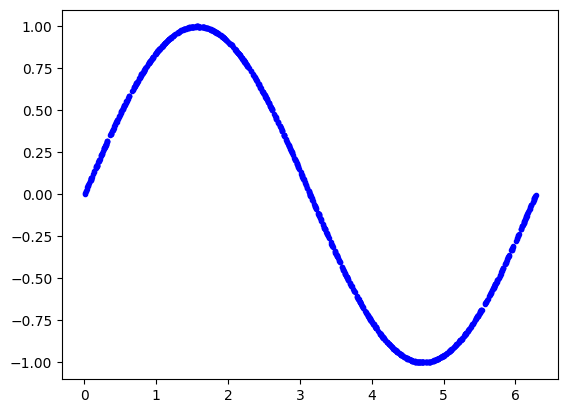

In [4]:
# We'll generate this many sample datapoints
SAMPLES = 1000

# Set a "seed" value, so we get the same random numbers each time we run this
# notebook. Any number can be used here.
SEED = 1337
np.random.seed(SEED)

# Generate a uniformly distributed set of random numbers in the range from
# 0 to 2π, which covers a complete sine wave oscillation
x_values = np.random.uniform(low=0, high=2*math.pi, size=SAMPLES)
x_values = np.float32(x_values)

# Shuffle the values to guarantee they're not in order
np.random.shuffle(x_values)

# Calculate the corresponding sine values
y_values = np.sin(x_values)

# Plot our data. The 'b.' argument tells the library to print blue dots.
plt.plot(x_values, y_values, 'b.')
plt.show()

Add noise to the data.

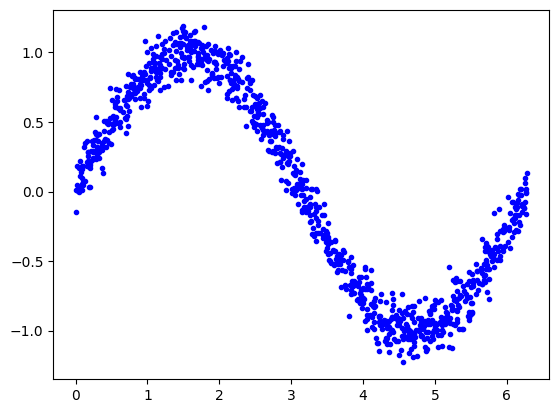

In [5]:
# Add a small random number to each y value
y_values += 0.1 * np.random.randn(*y_values.shape)

# Plot our data
plt.plot(x_values, y_values, 'b.')
plt.show()

Split the data into training, validation and test datasets

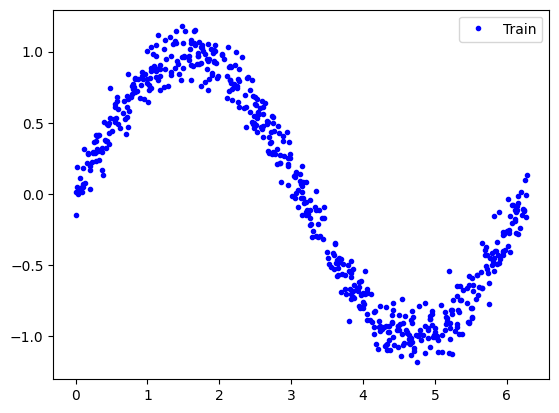

In [12]:
# We'll use 60% of our data for training and 20% for testing. The remaining 20%
# will be used for validation. Calculate the indices of each section.
TRAIN_SPLIT =  int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

# Use np.split to chop our data into three parts.
# The second argument to np.split is an array of indices where the data will be
# split. We provide two indices, so the data will be divided into three chunks.
x_train, x_validate, x_test = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_validate, y_test = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# Double check that our splits add up correctly
assert (x_train.size + x_validate.size + x_test.size) ==  SAMPLES

# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
#plt.plot(x_validate, y_validate, 'y.', label="Validate")
#plt.plot(x_test, y_test, 'r.', label="Test")
plt.legend()
plt.show()

Create the a simple sequential model with on layer of nodes.

In [13]:
# Define model architecture
class SinePredictor(nn.Sequential):
  def __init__(self, input_size, hidden_size, output_size):
    super(SinePredictor, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.fc3 = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.fc3(x)
    return x

# Define hyperparameters
input_size = 1  # Size of sine wave input (x-value)
hidden_size = 16  # Number of neurons in the hidden layer
output_size = 1  # Size of sine wave output (predicted y-value)

# Create the model instance
model = SinePredictor(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean squared error loss for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Adam optimizer


In [14]:
# Generate sample data (replace with your data generation process)
#x_train = torch.linspace(0, 10, 600)[:, None]  # Sample x values between 0 and 10
#y_train = torch.sin(x_train)  # Corresponding sine wave y values

x_train = torch.tensor(x_train)[:, None]
y_train = torch.tensor(y_train)[:, None]

print(x_train.size())


torch.Size([600, 1])


In [15]:
# Training loop (modify epochs and batch size as needed)
for epoch in range(200):
  for i in range(0, len(x_train), 30):  # Loop through data in batches of 30
    # Get a batch of data
    inputs = x_train[i:i+30]
    labels = y_train[i:i+30]

    # Clear gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)

    # Calculate loss
    loss = criterion(outputs, labels)

    # Backward pass and optimize
    loss.backward()
    optimizer.step()

# After training, predict on entire training data
predicted_y = model(x_train)

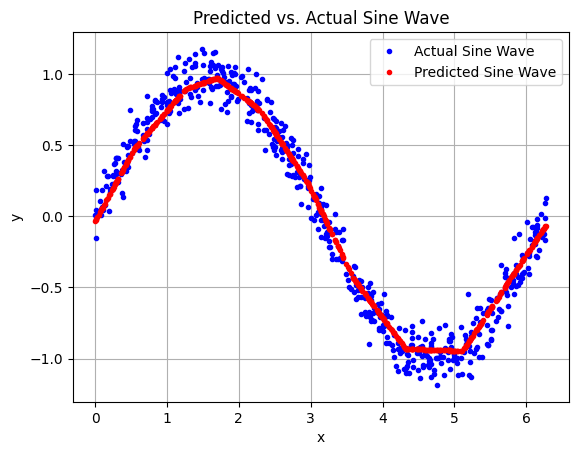

In [16]:
# Prepare data for plotting
x_train_np = x_train.squeeze().numpy()  # Convert tensor to numpy array for plotting
y_train_np = y_train.squeeze().numpy()
predicted_y_np = predicted_y.squeeze().detach().numpy()

# Plotting
plt.plot(x_train_np, y_train_np, '.b', label='Actual Sine Wave')
plt.plot(x_train_np, predicted_y_np, '.r', label='Predicted Sine Wave')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Predicted vs. Actual Sine Wave')
plt.grid(True)
plt.show()

Not sure how this next step works, but it is what converts the model to Verilog.

In [17]:
model_converter = Model(model)
model_converter.parse_layers()
model_converter.forward_range([[1.0, 100.0]])

In [18]:
print(model_converter)
verilog = model_converter.emit()

Linear(1 -> 16)
ReLU((16,))
Linear(16 -> 16)
Linear(16 -> 1)


In [19]:
print(verilog)

`timescale 1ns / 1ps

module layer_0_linear_1_16(in0, out0,out1,out2,out3,out4,out5,out6,out7,out8,out9,out10,out11,out12,out13,out14,out15);
    input [6:0] in0;

    output [5:0] out0;
    output [5:0] out1;
    output [6:0] out2;
    output [4:0] out3;
    output [4:0] out4;
    output [5:0] out5;
    output [4:0] out6;
    output [2:0] out7;
    output [6:0] out8;
    output [5:0] out9;
    output [3:0] out10;
    output [3:0] out11;
    output [5:0] out12;
    output [4:0] out13;
    output [5:0] out14;
    output [4:0] out15;

    
    reg [5:0] mul0;
    reg [5:0] mul1;
    reg [6:0] mul2;
    reg [4:0] mul3;
    reg [4:0] mul4;
    reg [5:0] mul5;
    reg [4:0] mul6;
    reg [2:0] mul7;
    reg [6:0] mul8;
    reg [5:0] mul9;
    reg [3:0] mul10;
    reg [3:0] mul11;
    reg [5:0] mul12;
    reg [4:0] mul13;
    reg [5:0] mul14;
    reg [4:0] mul15;

    reg [5:0] add0;
    reg [5:0] add1;
    reg [6:0] add2;
    reg [4:0] add3;
    reg [4:0] add4;
    reg [5:0] add5;
    reg [

Generate the test bench

In [20]:
verilog_tb = model_converter.emit_test_bench()
print(verilog_tb)

`timescale 1ns / 1ps

module tb_top;
        input [6:0] in0;
        output [2:0] out0;

    top dut(
        in0,
        out0
    );

    initial begin
        $dumpfile("tb_top.vcd");
        $dumpvars(0, tb_top);
        
        // Wait a bit before starting simulation
        #2;
        
                assign in0 = 0;

        $finish;
    end
endmodule



The next steps saves the verilog module and the testbench to a file.

In [21]:
with open('test.v', 'w') as f:
    f.write(verilog)

with open('test_tb.v', 'w') as f:
    f.write(verilog_tb)

## References
- [The Hello World of Deep Learning with Neural Networks](https://github.com/lmoroney/dlaicourse/blob/master/Course%201%20-%20Part%202%20-%20Lesson%202%20-%20Notebook.ipynb)
- [A Simple Neural Network from Scratch with PyTorch and Google Colab](https://medium.com/dair-ai/a-simple-neural-network-from-scratch-with-pytorch-and-google-colab-c7f3830618e0?source=collection_category---4------1-----------------------)
- [PyTorch Official Docs](https://pytorch.org/docs/stable/nn.html)
- [PyTorch 1.2 Quickstart with Google Colab](https://medium.com/dair-ai/pytorch-1-2-quickstart-with-google-colab-6690a30c38d)
- [A Gentle Intoduction to PyTorch](https://medium.com/dair-ai/pytorch-1-2-introduction-guide-f6fa9bb7597c)